In [80]:
import spectrum
from matplotlib import pyplot as plt
from astropy.stats import biweight_midvariance, biweight_location
import numpy as np
from scipy.interpolate import UnivariateSpline
import os
import glob

%matplotlib inline

In [81]:
#ff = ["../data/ncgama09E_013.fits.gz", "../data/ncgama09E_014.fits.gz"]
#ff = glob.glob("../data/ncgama09E_???.fits.gz")[:10]
#rr = [1/np.sqrt(np.pi), 2., 5., 10. ]

ff = glob.glob("../allinone/gama09Ffin_allone_0[21,49,71,72,82,98].fits.gz")

In [82]:
ifus = [21,71,72,82,98]

ff = ["../allinone/gama09Ffin_allone_{:03d}.fits.gz".format(ifu) for ifu in ifus]

In [138]:
r = 5.

Nbin = [1, 2, 5, 10, 30]
Nbin = [1]


# determine wavelength grid once
f = ff[1]
nc = spectrum.readSpectrum(f)
ww = nc.grid()

sss = np.zeros([len(ff),  len(ww)], dtype=float)

# create dictionary to hold binned spectra
bsss = {}
for nbin in Nbin:
    bsss[nbin] = np.zeros([ sss.shape[0] ,  (len(ww)// nbin)], dtype=float)


In [139]:
def bin_cube(nc, nbin):
    if nbin == 1:
        return nc
    
    bnc = nc.copy()

    bshape0 = nc.data.shape[0]//nbin 
    bnc.data = np.zeros([bshape0 , nc.data.shape[1], nc.data.shape[2]])


    slstart, slend = 0, nbin
    cnt = 0
    while slend <= nc.data.shape[0]:
        bnc.data[cnt] = np.nanmedian(nc.data[slstart:slend,:,:],axis=0)
        cnt += 1
        slstart += nbin
        slend += nbin
        
    return bnc

In [140]:
bww = {}
for nbin in Nbin:
    bww[nbin] = ww[:(len(ww)// nbin)*nbin].reshape(-1, nbin).mean(axis=1)

In [141]:
int(nc.data.shape[0] // 2)*.965

499.87

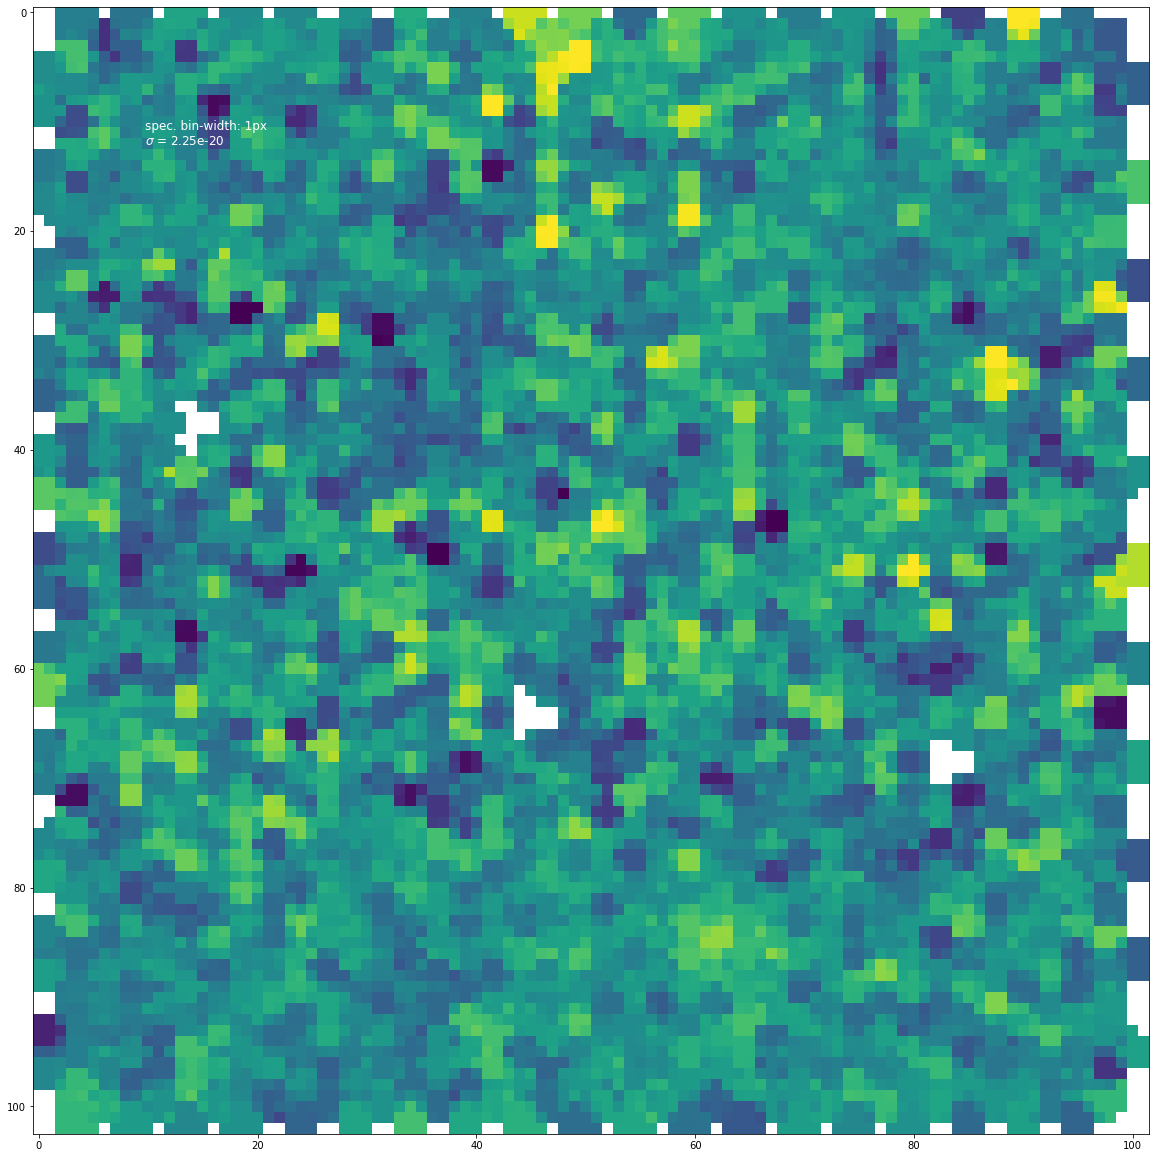

In [142]:
vmin=-0.0075
vmax=0.0075
size = 12

f = plt.figure(figsize=[20,40])


for i, nbin in enumerate(Nbin):
    bnc = bin_cube(nc, nbin)

    ax = plt.subplot(1,len(Nbin), i + 1)
    im = bnc.data[int(bnc.data.shape[0] // 2*.965)]
    plt.imshow(im, vmin=vmin, vmax=vmax)
    ii = np.isnan(im)
    plt.text(.1,.9,"spec. bin-width: {}px\n$\sigma$ = {:.2e}".format(nbin, np.sqrt(biweight_midvariance(im[~ii])) * 1e-17 ),\
             transform=ax.transAxes, color='w', size=size, va='top', ha='left')


In [143]:
2.25e-20/np.sqrt(30.)

4.107919181288746e-21

In [144]:
np.sqrt(biweight_midvariance(im[~ii])) 

0.0022527049288084706

In [151]:
for i, f in enumerate(ff):
        print("operating on ", f)
        nc = spectrum.readSpectrum(f)
        xx,yy = np.arange(nc.data.shape[2]), np.arange(nc.data.shape[1])
        XX,YY = np.meshgrid(xx,yy)
        xc,yc = np.mean(xx), np.mean(yy)  
        rmax = r/.5 # arcsec to pixel
        ddsq = (((XX-xc)**2.) + ((YY-yc)**2))
        mask = ddsq <= rmax**2.

        
        for nbin in Nbin:
            bnc = bin_cube(nc, nbin)

            #ss = {}
            for k in range(len(bww)):
                bmeanfluxes = np.sqrt(biweight_midvariance(  bnc.data[k][mask]) )
                bsss[nbin][i,k] = bmeanfluxes 





operating on  ../allinone/gama09Ffin_allone_021.fits.gz
operating on  ../allinone/gama09Ffin_allone_071.fits.gz
operating on  ../allinone/gama09Ffin_allone_072.fits.gz
operating on  ../allinone/gama09Ffin_allone_082.fits.gz
operating on  ../allinone/gama09Ffin_allone_098.fits.gz


In [152]:
bnc.data.shape

(1036, 103, 102)

In [153]:
bsss[nbin][0]

array([nan,  0.,  0., ...,  0.,  0.,  0.])

In [149]:
bmeanfluxes = np.sqrt(biweight_midvariance(  bnc.data[k][mask]) )

In [150]:
bmeanfluxes.shape

()

In [146]:
bsss[nbin][0]

array([nan,  0.,  0., ...,  0.,  0.,  0.])

In [124]:
bsss[1]

array([[nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]])

Text(0, 0.5, 'noiselevel  per 10 arcsec \naperture [$10^{-17} erg s^{-1} A^{-1} cm^{-2}$]')

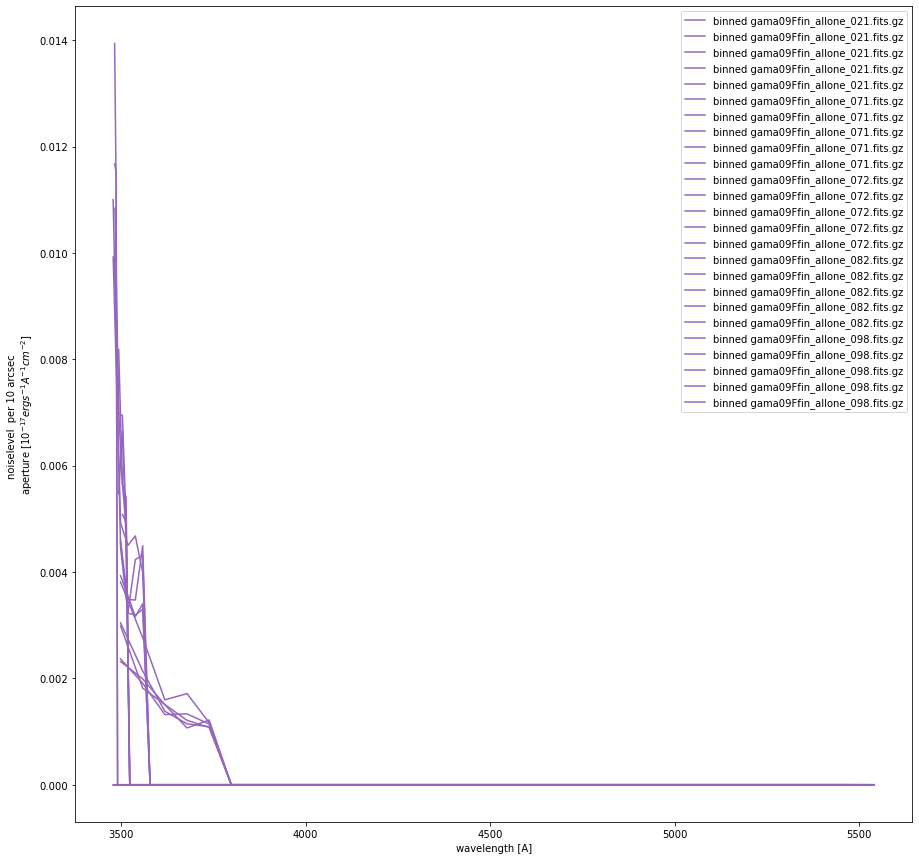

In [122]:

f = plt.figure(figsize=[15,15])

for i, f in enumerate(ff[:]):
    
    #yy = sss[i]
    #byy = bsss[i]
    
    h,t = os.path.split(f)
    #l = plt.plot(ww, yy, label="{}".format(t), alpha=.1)
    
    for nbin in Nbin:
        byy = bsss[nbin][i]
        plt.plot(bww[nbin], byy, label="binned {}".format(t),color=l[0].get_color())

    #ii = ww > 0.
    #spl = UnivariateSpline(ww[ii], ss[r][ii], k=3, s=smoothing)
    #kappa = 3.5
    #sigma = np.nanstd(ss[r]-spl(ww))

    #jj = (np.abs(ss[r]-spl(ww)) < kappa*sigma) 
    #spl = UnivariateSpline(ww[ii*jj],  ss[r][ii*jj], k=3, s=smoothing)

    #plt.plot(ww, spl(ww), label="{:.1f} arcsec".format(r*2))

#plt.legend()
plt.legend()

plt.xlabel('wavelength [A]')
plt.ylabel('noiselevel  per 10 arcsec \naperture [$10^{-17} erg s^{-1} A^{-1} cm^{-2}$]')

/home/idies/miniconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


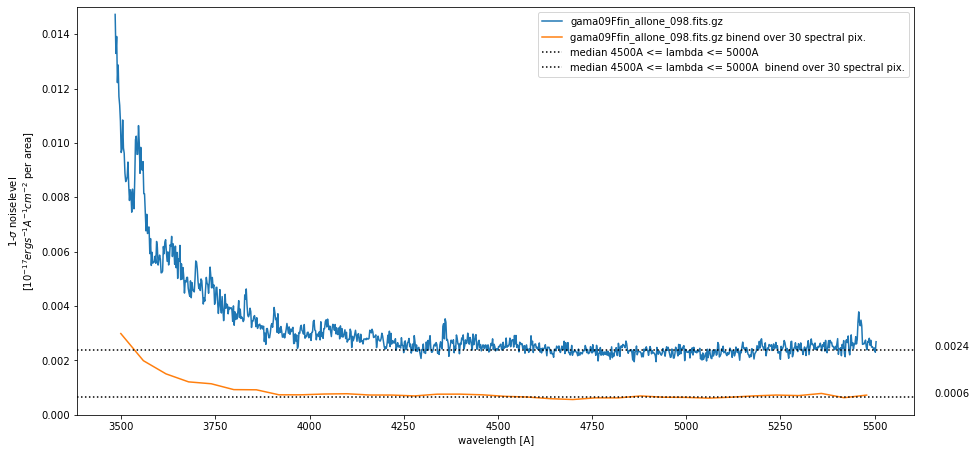

In [95]:
#smoothing = 0.003

dLambda = 5.5
dLambda_native = 2.
A_native = 0.5**2.
#A = 5.**2*np.pi
A = 0.5**2.


fig = plt.figure(figsize=[15,7.5])

mm = np.nanmedian( sss, axis=0 )
bmm = np.nanmedian( bsss, axis=0 )
h,t = os.path.split(f)
#plt.plot(ww, yy/np.sqrt(dLambda/dLambda_native)/np.sqrt(A/A_native))


plt.plot(ww, mm, label="{}".format(t))
plt.plot(bww, bmm, label="{} binend over {} spectral pix.".format(t, Nbin))

#ii = ww > 0.
#spl = UnivariateSpline(ww[ii], ss[r][ii], k=3, s=smoothing)
#kappa = 3.5
#sigma = np.nanstd(ss[r]-spl(ww))

#jj = (np.abs(ss[r]-spl(ww)) < kappa*sigma) 
#spl = UnivariateSpline(ww[ii*jj],  ss[r][ii*jj], k=3, s=smoothing)

#plt.plot(ww, spl(ww), label="{:.1f} arcsec".format(r*2))

#plt.yscale('log')

plt.xlabel('wavelength [A]')
plt.ylabel('1-$\sigma$ noiselevel \n[$10^{-17} erg s^{-1} A^{-1} cm^{-2}$ per area]')
#plt.ylim([0.,0.035])
plt.ylim([0.,0.015])


ii = (ww >= 4500.) * (ww <= 5000.)
plt.axhline(np.nanmedian(mm[ii]), c='k', ls=':', label="median 4500A <= lambda <= 5000A")
plt.text(5660,np.nanmedian(mm[ii]), "{:.4f}".format(np.nanmedian(mm[ii])))


ii = (bww >= 4500.) * (bww <= 5000.)
plt.axhline(np.nanmedian(bmm[ii]), c='k', ls=':', \
            label="median 4500A <= lambda <= 5000A  binend over {} spectral pix.".format(Nbin))
plt.text(5660,np.nanmedian(bmm[ii]), "{:.4f}".format(np.nanmedian(bmm[ii])), \
            label="median 4500A <= lambda <= 5000A  binend over {} spectral pix.".format(Nbin) )


plt.legend()